In [1]:
import os
import shutil

# Reduce TensorFlow info logs (optional)
# os.environ.setdefault("TF_CPP_MIN_LOG_LEVEL", "2")

import numpy as np
from scipy.stats import unitary_group
from opt_einsum import contract

import tensorflow as tf
from src.QDDPM_tf import OneQubitDiffusionModel, QDDPM
from src.QDDPM_tf import naturalDistance, WassDistance

import time

import matplotlib.pyplot as plt
from matplotlib import rc

# Use LaTeX only if it exists on this machine (no sudo required)
rc('text', usetex=(shutil.which('latex') is not None))
rc('axes', linewidth=3)

2025-12-29 21:17:16.555979: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-29 21:17:16.573475: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-12-29 21:17:16.597521: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-12-29 21:17:16.597558: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-12-29 21:17:16.612945: I tensorflow/core/platform/cpu_feature_gua

# Generate diffusion data

In [2]:
def circleYGen(N_train, seed=None):
    '''
    generate random quantum states from RY(\phi)|0>
    assume uniform distribution
    '''
    np.random.seed(seed)
    phis = np.random.uniform(0, 2*np.pi, N_train)
    states = np.vstack((np.cos(phis), np.sin(phis))).T
    return states.astype(np.complex64)

distance measure behavior in the forward process

In [3]:
n = 1
T = 40
Ndata = 10
diff_hs = 1e-3*np.arange(1, T+1)**2

model_diff = OneQubitDiffusionModel(T, Ndata)
X = tf.convert_to_tensor(circleYGen(Ndata, seed=12))
Xout = np.zeros((T+1, Ndata, 2**n), dtype=np.complex64)
Xout[0] = X.numpy()

for t in range(1, T+1):
    Xout[t] = model_diff.set_diffusionData_t(t, X, diff_hs[:t], seed=t).numpy()
    print(t)
np.save('data/circle/circleYDiff_n1T%d_N%d.npy'%(T, Ndata), Xout)

2025-12-29 21:17:21.734251: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2025-12-29 21:17:21.735307: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79178 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:31:00.0, compute capability: 8.0
2025-12-29 21:17:21.735611: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2025-12-29 21:17:21.736696: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 79178 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:b1:00.0, compute capability: 8.0


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40


Text(0.5, 0, '$t$')

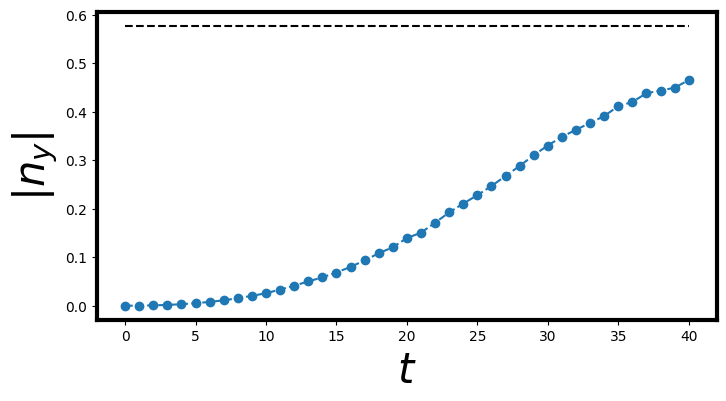

In [4]:
# plot the standard deviation of ny evolution
N = 5000
sy = np.array([[0,-1j],[1j,0]])
X = np.load('data/circle/circleYDiff_n1T40_N%d.npy'%N)
ys = contract('tmi, ij, tmj->tm', X.conj(), sy, X)

plt.figure(figsize=(8, 4))
plt.plot(range(41), np.mean(np.abs(ys), axis=1), 'o--')
plt.plot(range(41), 1/np.sqrt(3)*np.ones(41), '--', c='k')
plt.ylabel(r'$|n_y|$', fontsize=30)
plt.xlabel(r'$t$', fontsize=30)

# compare distance measures

In [5]:
N = 500
T = 40
X = tf.convert_to_tensor(np.load('data/circle/circleYDiff_n1T40_N5000.npy'))
X0 = tf.convert_to_tensor(circleYGen(N, seed=19))

mmd = np.zeros(T+1)
wass = np.zeros(T+1)
for t in range(T+1):
    np.random.seed()
    idx = np.random.choice(10*N, N, replace=False)
    mmd[t] = naturalDistance(X0, X[t, idx])
    wass[t] = WassDistance(X0, X[t, idx])

np.save('data/circle/circleYDiffdists_n1T40_N%d.npy'%N, np.vstack((mmd, wass)))

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: annotated name 'path_tuple' can't be nonlocal (__autograph_generated_file5iosd5sv.py, line 262)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: annotated name 'path_tuple' can't be nonlocal (__autograph_generated_file5iosd5sv.py, line 262)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: Unable to locate the source code of <function _gcd_import at 0x7f299fd2e310>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are cer

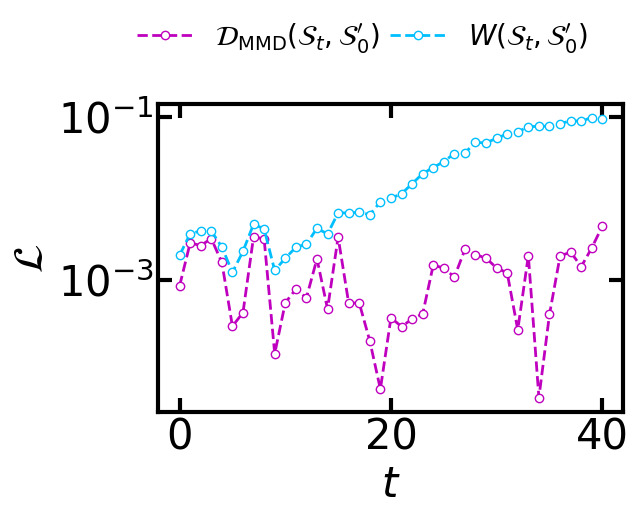

In [6]:
# plot different distance measures
N = 500
dists = np.load('data/circle/circleYDiffdists_n1T40_N%d.npy'%N)

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(dists[0], 'o--', mfc='white', markersize=6, lw=2, c='m', 
        label=r'$\mathcal{D}_{\rm MMD}(\mathcal{S}_t,\mathcal{S}^\prime_0)$')
ax.plot(dists[1], 'o--', mfc='white', markersize=6, lw=2, c='deepskyblue', 
        label=r'$W(\mathcal{S}_t,\mathcal{S}^\prime_0)$')

ax.legend(fontsize=20, framealpha=0, ncol=2, columnspacing=0.4, loc='upper left', bbox_to_anchor=(-0.1, 1.35))
ax.set_yscale('log')
ax.set_xlabel(r'$t$', fontsize=30)
ax.set_ylabel(r'$\mathcal{L}$', fontsize=30)
ax.tick_params(direction='in', length=10, width=3, top='on', right='on', labelsize=30)


# Training

In [7]:
def Training_t(model, t, inputs_T, params_tot, Ndata, epochs):
    '''
    training for the backward PQC at step t using whole dataset
    Args:
    model: QDDPM model
    t: diffusion step
    params_tot: collection of PQC parameters for steps > t 
    Ndata: number of samples in training data set
    epochs: number of iterations
    '''
    input_tplus1 = model.prepareInput_t(inputs_T, params_tot, t, Ndata) # prepare input
    states_diff = model.states_diff
    loss_hist = [] # record of training history

    # initialize parameters
    tf.random.set_seed(None)
    params_t = tf.Variable(tf.random.normal([2 * model.n_tot * model.L]))
    # set optimizer and learning rate decay
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)

    t0 = time.time()
    for step in range(epochs):
        indices = np.random.choice(states_diff.shape[1], size=Ndata, replace=False)
        true_data = states_diff[t, indices]
        with tf.GradientTape() as tape:
            output_t = model.backwardOutput_t(input_tplus1, params_t)
            loss = WassDistance(output_t, true_data)
        grads = tape.gradient(loss, [params_t])
        optimizer.apply_gradients(zip(grads, [params_t]))

        loss_hist.append(tf.stop_gradient(loss)) # record the current loss
        
        if step%100 == 0:
            loss_value = loss_hist[-1]
            print("Step %s, loss: %s, time elapsed: %s seconds"%(step, loss_value, time.time() - t0))
        
    return tf.stop_gradient(params_t), tf.squeeze(tf.stack(loss_hist))

In [10]:
n, na = 1, 2
T = 40
L = 6
Ndata = 500
epochs = 5001

diffModel = OneQubitDiffusionModel(T, Ndata)
inputs_T = diffModel.HaarSampleGeneration(Ndata, seed=22)

states_diff = np.load('data/circle/circleYDiff_n1T40_N5000.npy')
model = QDDPM(n=n, na=na, T=T, L=L)
model.set_diffusionSet(states_diff)

# If you already have trained artifacts, skip training to save time.
combined_params_path = 'data/circle/QDDPMcircleYparams_n1na2T40L6_wd.npy'
combined_loss_path = 'data/circle/QDDPMcircleYloss_n1na2T40L6_wd.npy'

expected_param_dim = 2 * (n + na) * L
skip_training = False
if os.path.exists(combined_params_path) and os.path.exists(combined_loss_path):
    combined_params = np.load(combined_params_path)
    combined_loss = np.load(combined_loss_path)
    if combined_params.shape == (T, expected_param_dim) and combined_loss.shape[0] == T:
        print('[training] Found existing results; skipping training:')
        print('  params:', combined_params_path, 'shape=', combined_params.shape)
        print('  loss  :', combined_loss_path, 'shape=', combined_loss.shape)
        # Lightweight sanity checks (cannot prove provenance, only consistency).
        print('  params finite:', np.isfinite(combined_params).all())
        print('  loss   finite:', np.isfinite(combined_loss).all())
        print('  loss min/max :', float(np.min(combined_loss)), float(np.max(combined_loss)))
        skip_training = True
    else:
        print('[training] Existing files found but shapes look unexpected; will train instead.')
        print('  params shape:', combined_params.shape, 'expected:', (T, expected_param_dim))
        print('  loss   shape:', combined_loss.shape, 'expected first dim:', T)
else:
    combined_params = np.load(combined_params_path) if os.path.exists(combined_params_path) else None

if not skip_training:
    tf.random.set_seed(None)
    params_t = tf.Variable(tf.random.normal([2 * model.n_tot * model.L]))
    for t in range(T-1, -1, -1):
        params_tot = np.zeros((T, expected_param_dim))
        for tt in range(t+1, T):
            per_step_path = 'data/circle/QDDPMcircleYparams_n1na2T40L6_t%d_wd.npy'%tt
            if os.path.exists(per_step_path):
                params_tot[tt] = np.load(per_step_path)
            elif combined_params is not None:
                params_tot[tt] = combined_params[tt]
            else:
                raise FileNotFoundError(
                    f"Missing params for step tt={tt}. Expected '{per_step_path}' or '{combined_params_path}'."
                )
            
        params, loss_hist = Training_t(model, t, inputs_T, params_tot, Ndata, epochs)
        np.save('data/circle/QDDPMcircleYparams_n1na2T40L6_t%d_wd.npy'%t, params.numpy())
        np.save('data/circle/QDDPMcircleYlosshist_n1na2T40L6_t%d_wd.npy'%t, loss_hist.numpy())

[training] Found existing results; skipping training:
  params: data/circle/QDDPMcircleYparams_n1na2T40L6_wd.npy shape= (40, 36)
  loss  : data/circle/QDDPMcircleYloss_n1na2T40L6_wd.npy shape= (40, 5000)
  params finite: True
  loss   finite: True
  loss min/max : 0.001250681933015585 0.24922694265842438


# Performance

## generate training and testing data

In [11]:
# collect result (optional)
n, na = 1, 2
T = 40
L = 6
N_train = 5000

combined_params_path = 'data/circle/QDDPMcircleYparams_n1na2T40L6_wd.npy'
combined_loss_path = 'data/circle/QDDPMcircleYloss_n1na2T40L6_wd.npy'

if os.path.exists(combined_params_path) and os.path.exists(combined_loss_path):
    # Avoid overwriting existing combined artifacts.
    print('[collect] Combined params/loss already exist; skipping collection.')
    print('  params:', combined_params_path)
    print('  loss  :', combined_loss_path)
else:
    loss_tot = np.zeros((T, 5000))
    params_tot = np.zeros((T, 2*(n+na)*L))
    for t in range(T):
        loss_tot[t] = np.load('data/circle/QDDPMcircleYlosshist_n1na2T40L6_t%d_wd.npy'%t)
        params_tot[t] = np.load('data/circle/QDDPMcircleYparams_n1na2T40L6_t%d_wd.npy'%t)
    # Save with correct names (params -> params_tot, loss -> loss_tot)
    np.save(combined_params_path, params_tot)
    np.save(combined_loss_path, loss_tot)
    print('[collect] Saved combined artifacts:', combined_params_path, 'and', combined_loss_path)

[collect] Combined params/loss already exist; skipping collection.
  params: data/circle/QDDPMcircleYparams_n1na2T40L6_wd.npy
  loss  : data/circle/QDDPMcircleYloss_n1na2T40L6_wd.npy


In [12]:
# generate data

n, na = 1, 2
T = 40
L = 6
Ndata = 500

diffModel = OneQubitDiffusionModel(T, Ndata)
inputs_T_tr = diffModel.HaarSampleGeneration(Ndata, seed=22)
inputs_T_te = diffModel.HaarSampleGeneration(Ndata, seed=23)

params_tot = np.load('data/circle/QDDPMcircleYparams_n1na2T40L6_wd.npy')

model = QDDPM(n=n, na=na, T=T, L=L)

data_tr = model.backDataGeneration(inputs_T_tr, params_tot, Ndata)[:, :, :2**n].numpy()
data_te = model.backDataGeneration(inputs_T_te, params_tot, Ndata)[:, :, :2**n].numpy()

np.save('data/circle/QDDPMcircleYtrainGen_n1na2T40L6_wd.npy', data_tr)
np.save('data/circle/QDDPMcircleYtestGen_n1na2T40L6_wd.npy', data_te)

## visualize in $\langle Y\rangle^2$

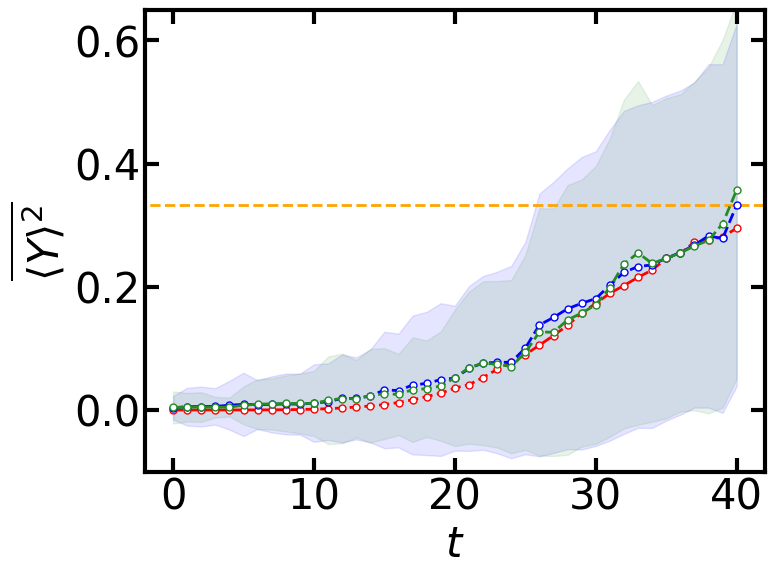

In [13]:
# plot training and test result (in vertical representation)
n, na = 1, 2
T = 40
L = 6
Ndata = 500

states_diff = np.load('data/circle/circleYDiff_n1T40_N5000.npy')
states_tr = np.load('data/circle/QDDPMcircleYtrainGen_n1na2T40L6_wd.npy')
states_te = np.load('data/circle/QDDPMcircleYtestGen_n1na2T40L6_wd.npy')

sy = np.array([[0,-1j], [1j, 0]], dtype=np.complex64)
ys_diff = np.real(contract('tmi, ij, tmj->tm', states_diff.conj(), sy, states_diff))
ys_train = np.real(contract('tmi, ij, tmj->tm', states_tr.conj(), sy, states_tr))
ys_test = np.real(contract('tmi, ij, tmj->tm', states_te.conj(), sy, states_te))

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(range(T+1), np.mean(ys_diff**2, axis=1), 'o--', markersize=5, mfc='white', lw=2, c='r', 
            zorder=5, label=r'$\rm diffusion$')

ax.plot(range(T+1), np.mean(ys_train**2, axis=1), 'o--', markersize=5, mfc='white', lw=2, c='b', 
            zorder=5, label=r'$\rm training$')
ax.fill_between(range(T+1), np.mean(ys_train**2, axis=1)-np.std(ys_train**2, axis=1), 
                    np.mean(ys_train**2, axis=1)+np.std(ys_train**2, axis=1), color='b', alpha=0.1)

ax.plot(range(T+1), np.mean(ys_test**2, axis=1), 'o--', markersize=5, mfc='white', lw=2, c='forestgreen', 
            zorder=5, label=r'$\rm testing$')
ax.fill_between(range(T+1), np.mean(ys_test**2, axis=1)-np.std(ys_test**2, axis=1), 
                    np.mean(ys_test**2, axis=1)+np.std(ys_test**2, axis=1), color='forestgreen', alpha=0.1)

ax.hlines(1/3., xmin=-10, xmax=50, ls='--', lw=2, color='orange')
ax.set_xticks(np.arange(0, T+1, 10))
ax.set_yticks(np.arange(0, 7, 2)*0.1)
ax.set_xlim(-2, 42)
ax.set_ylim(-0.1, 0.65)
ax.set_ylabel(r'$\overline{\langle Y\rangle^2}$', fontsize=30)
ax.set_xlabel(r'$t$', fontsize=30)
ax.tick_params(direction='in', length=10, width=3, top='on', right='on', labelsize=30)


## visualize in Wasserstein distance

In [14]:
# calculation
X = tf.convert_to_tensor(np.load('data/circle/circleYDiff_n1T40_N5000.npy'))
X_train = tf.convert_to_tensor(np.load('data/circle/QDDPMcircleYtrainGen_n1na2T40L6_wd.npy'))
X_test = tf.convert_to_tensor(np.load('data/circle/QDDPMcircleYtestGen_n1na2T40L6_wd.npy'))
X0 = tf.convert_to_tensor(circleYGen(5000, seed=19))

nd = np.zeros((3, 41))
for t in range(41):
    idx = np.random.choice(5000, 500, replace=False)
    nd[0, t] = WassDistance(X0, X[t, idx])
    nd[1, t] = WassDistance(X0, X_train[t])
    nd[2, t] = WassDistance(X0, X_test[t])
np.save('data/circle/QDDPMcircleYGenloss_n1na2T40L6_wd.npy', nd)

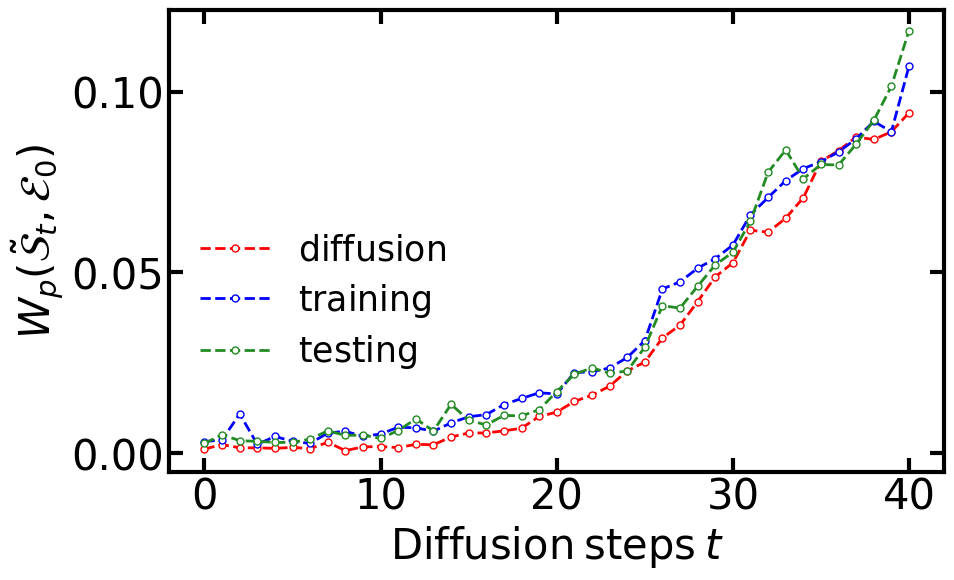

In [15]:
nd_gen = np.load('data/circle/QDDPMcircleYGenloss_n1na2T40L6_wd.npy')

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(nd_gen[0], 'o--', markersize=5, mfc='white', lw=2, c='r', label=r'$\rm diffusion$')
ax.plot(nd_gen[1], 'o--', markersize=5, mfc='white', lw=2, c='b', label=r'$\rm training$')
ax.plot(nd_gen[2], 'o--', markersize=5, mfc='white', lw=2, c='forestgreen', label=r'$\rm testing$')
ax.legend(loc='lower left', bbox_to_anchor=(0., 0.15), fontsize=25, framealpha=0, labelspacing=0.4)
ax.set_xlabel(r'${\rm Diffusion\:steps}\:t$', fontsize=30)
ax.set_ylabel(r'$W_p(\tilde{\mathcal{S}}_t, \mathcal{E}_0)$', fontsize=30)
ax.tick_params(direction='in', length=10, width=3, top='on', right='on', labelsize=30)

## plot training history

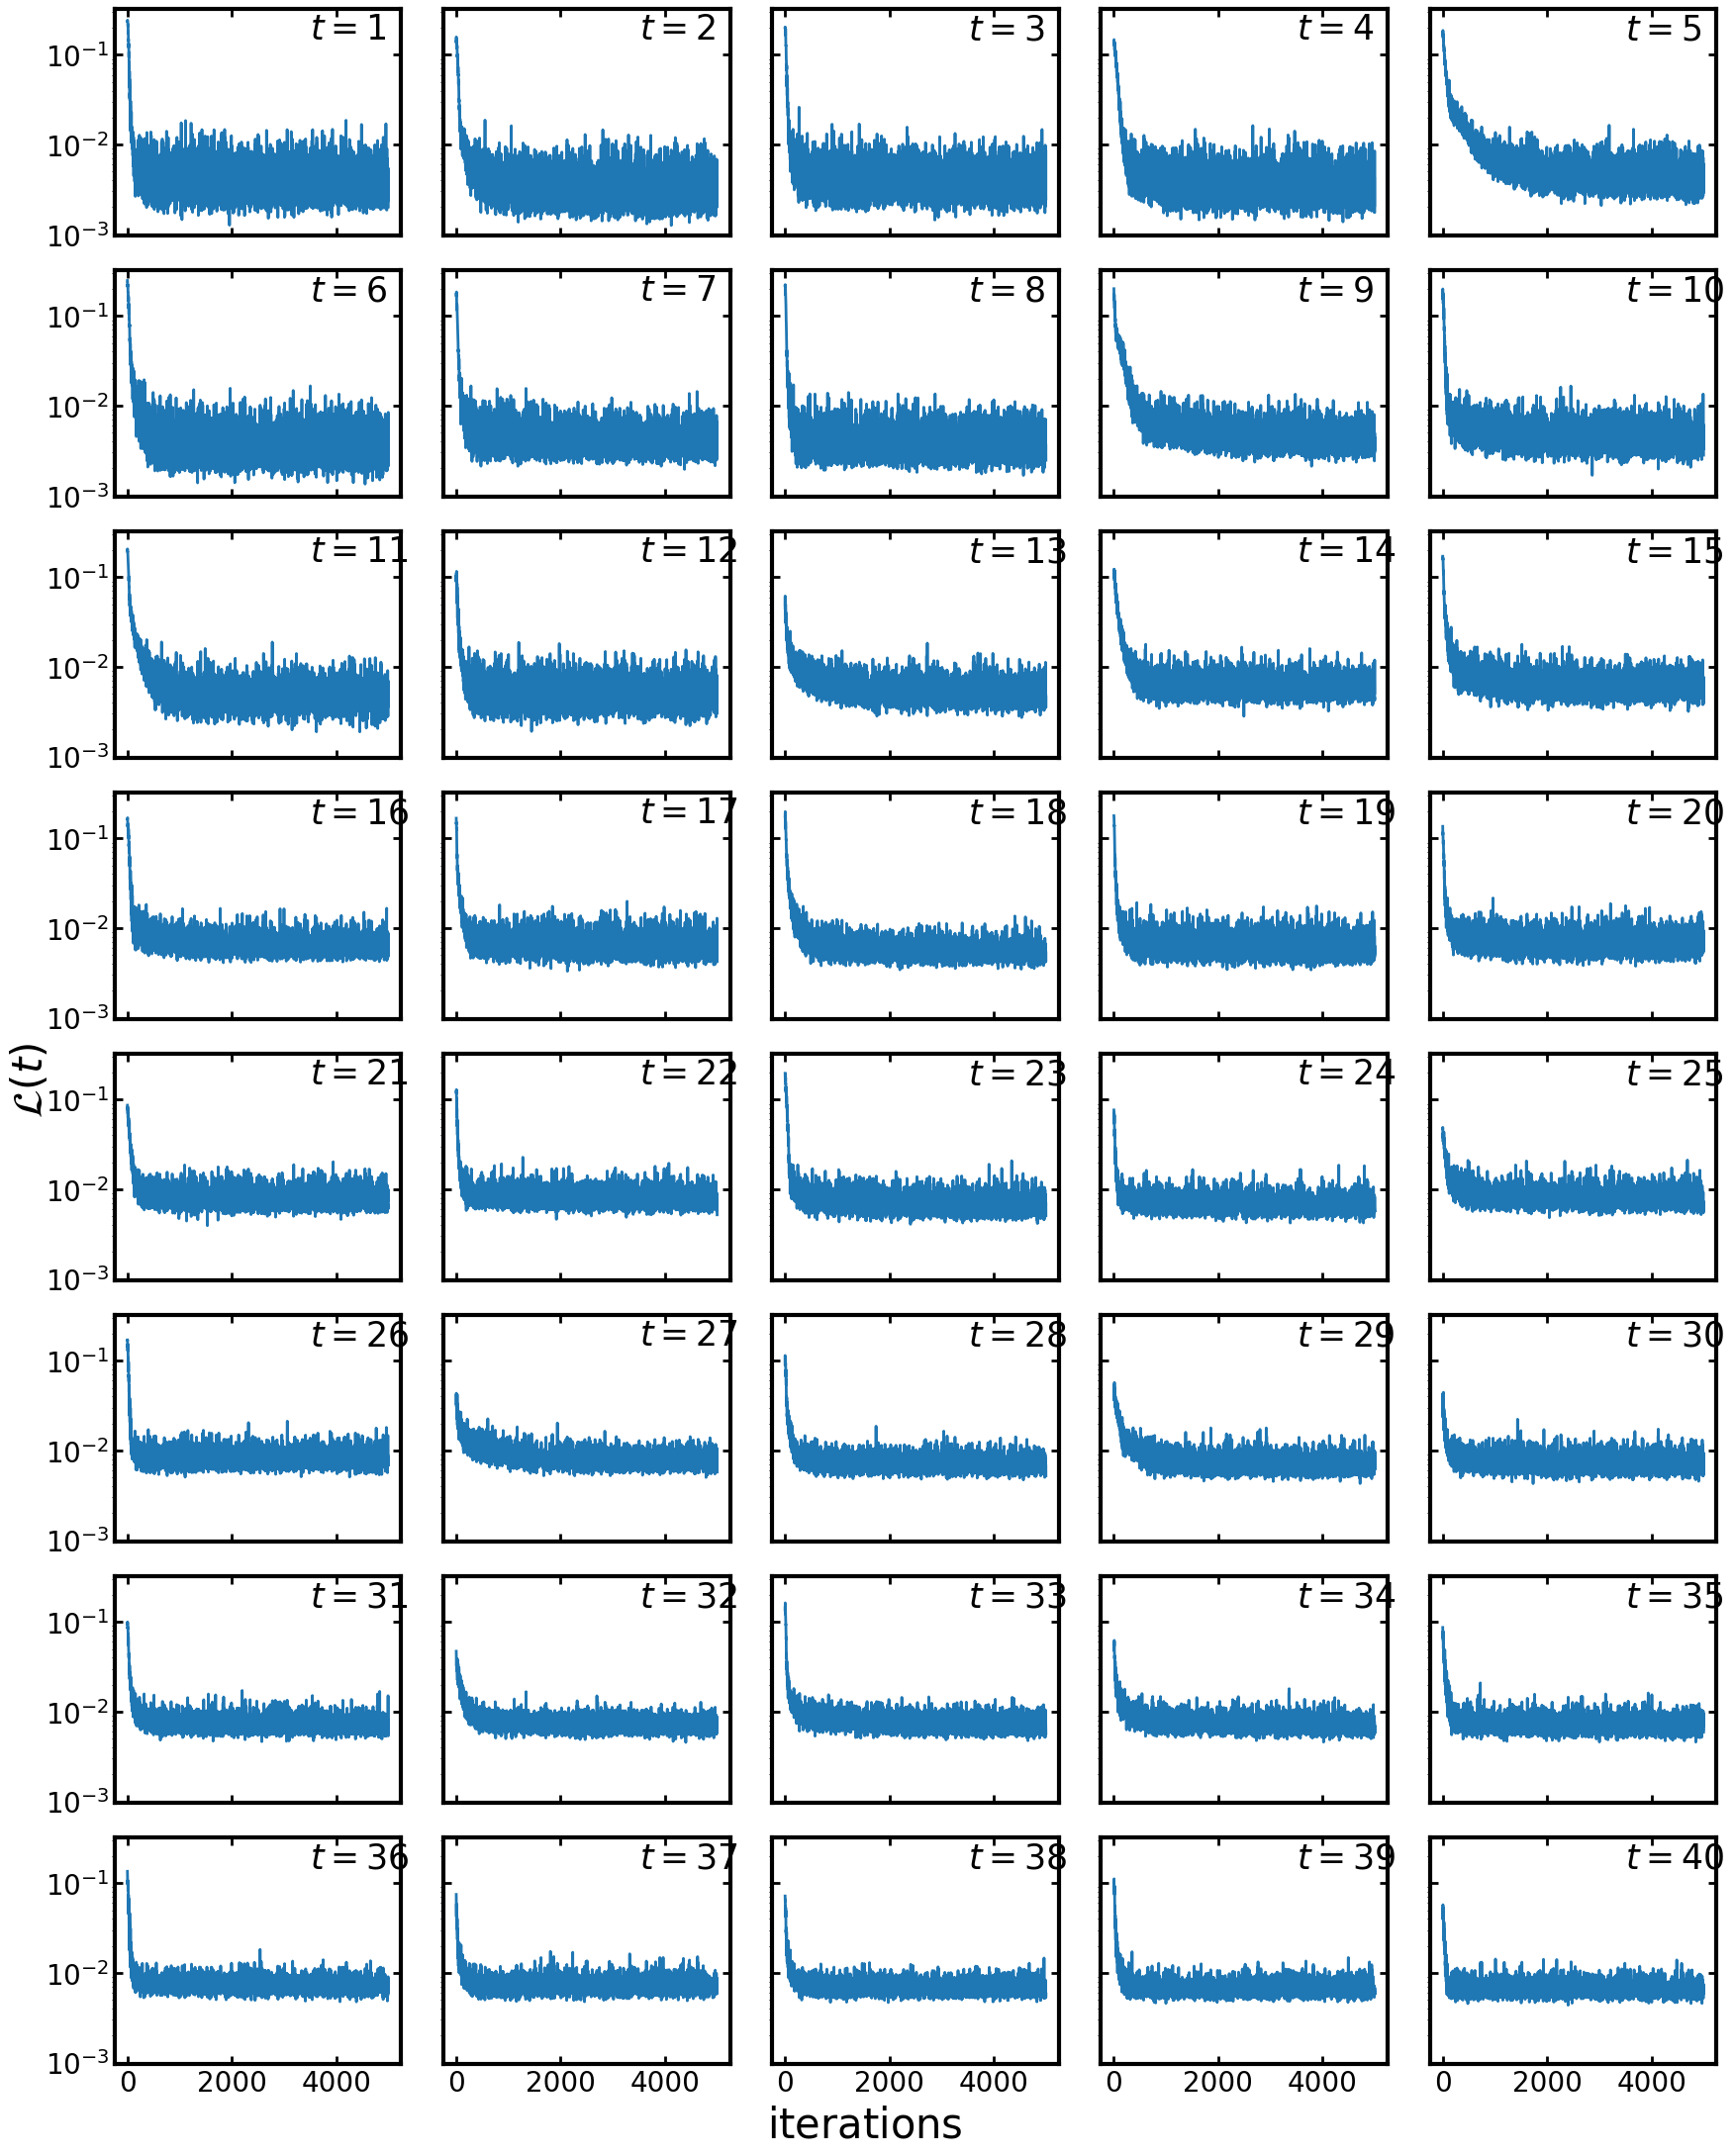

: 

In [ ]:
loss = np.load('data/circle/QDDPMcircleYloss_n1na2T40L6_wd.npy')
fig, axs = plt.subplots(8, 5, figsize=(18, 22), sharex=True, sharey=True)
for i in range(40):
    axs[i//5, i%5].plot(loss[i], lw=2)
    axs[i//5, i%5].tick_params(direction='in', length=6, width=2, top='on', right='on', labelsize=20)
    axs[i//5, i%5].text(x=3500, y=0.15, s=r'$t=%d$'%(i+1), fontsize=25)
    axs[i//5, i%5].set_yscale('log')
fig.supxlabel(r'$\rm iterations$', fontsize=30)
fig.supylabel(r'$\mathcal{L}(t)$', fontsize=30)
plt.tight_layout()